## Este es el test para sacar los minimos y maximos de los histogramas

Para calcular los vmin, vmax uso rgal para las estrellas y gas y uso rvir para la materia oscura.

In [8]:
import matplotlib.pyplot as plt
import h5py
import rotation_mio as rot
import numpy as np
import sphviewer as sph
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time_conversion as time

ID = np.loadtxt('../_data/my_halos.dat')[:,0]

path = '/store/erebos/omarioni/_simulations/snap_127/'

results = []

for i in range(12):

    snap = h5py.File(path + 'subhalo_'+str('%d'%ID[i])+'.h5py', 'r')
    
    aexp = snap['/Time'][()]
    h    = snap['/h'][()]
    Om_L = snap['/Omega_Lambda'][()]
    Om_M = snap['/Omega_0'][()]
    Rvir = snap['/R200'][()]
    
    pstr = snap['/Str/Coordinates'][()]
    mstr = snap['/Str/Masses'][()]
    vstr = snap['/Str/Velocities'][()]
    
    pgas = snap['/Gas/Coordinates'][()]
    mgas = snap['/Gas/Masses'][()]
    
    pdrk = snap['/Drk/Coordinates'][()]
    mdrk = snap['/Drk/Masses'][()]
    
    sft  = snap['/Str/FormationTime'][()]
    met  = snap['/Str/Metallicity'][()]
    tmet = snap['/Str/Total_Metallicity'][()]
    
    amask, = np.where(sft>0) #aca puede haber particulas con age<0, esas no son estrellas son gas cells.
    ages = time.conv2(sft[amask], h, Om_L, Om_M) #transformo el tiempo de formacion de factor de escala a Gyr
    age  = np.max(ages) - ages #lo resto asi saco la edad de las particulas (inverso al tiempo de form)
    
    Ztot = tmet[amask]/0.0127
    
    xstr = pstr[amask,0]*aexp/h
    ystr = pstr[amask,1]*aexp/h
    zstr = pstr[amask,2]*aexp/h
    rstr = np.sqrt(xstr**2+ystr**2+zstr**2)
    
    v_x = vstr[amask,0] *np.sqrt(aexp)
    v_y = vstr[amask,1] *np.sqrt(aexp)
    v_z = vstr[amask,2] *np.sqrt(aexp)
    
    #----------------------masas----------------------------
    # print(mstr[~amask]*1e10/h)
    # print(len(amask))
    # print(len(mstr))
    # print(len(mstr)-len(amask))
    mstr = mstr[amask]*1e10/h
    
    mgas = mgas*1e10/h
    mdrk = mdrk*1e10/h
    
    rgal = 0.15*Rvir*aexp/h
    
    limit, = np.where(rstr < rgal)
    rsort = np.argsort(rstr[limit])
    Mc = np.cumsum(mstr[limit][rsort])
    Mgal = Mc[-1]
    limit50, = np.where(Mc < Mgal/2)
    r50 = rstr[limit][rsort][limit50][-1]
    
    #---aca paso las coordenadas respecto al centro de la galaxia------
    
    xgas = pgas[:,0]*aexp/h
    ygas = pgas[:,1]*aexp/h
    zgas = pgas[:,2]*aexp/h
    rgas = np.sqrt(xgas**2+ygas**2+zgas**2)
    
    xdrk = pdrk[:,0]*aexp/h
    ydrk = pdrk[:,1]*aexp/h
    zdrk = pdrk[:,2]*aexp/h
    rdrk = np.sqrt(xdrk**2+ydrk**2+zdrk**2)
    
    veloc,=np.where(rstr < r50/2.)
    
    #----------componentes de la velocidad del centro de masa------------
    vxcm = sum(mstr[veloc]*v_x[veloc])/sum(mstr[veloc])
    vycm = sum(mstr[veloc]*v_y[veloc])/sum(mstr[veloc])
    vzcm = sum(mstr[veloc]*v_z[veloc])/sum(mstr[veloc])
    
    #----- velocidades de las estrellas respecto del centro de masa de la galaxia---------
    vx = v_x - vxcm
    vy = v_y - vycm
    vz = v_z - vzcm
    
    e1x,e2x,e3x,e1y,e2y,e3y,e1z,e2z,e3z = rot.rot1(mstr,xstr,ystr,zstr,vx,vy,vz,r50/2.)
    
    # posiciones de particulas que se quiere graficar
    # como lo de arriba me da los versores hago las posiciones con esto 
    
    xn_str = e1x*xstr + e1y*ystr + e1z*zstr
    yn_str = e2x*xstr + e2y*ystr + e2z*zstr
    zn_str = e3x*xstr + e3y*ystr + e3z*zstr
    
    xn_gas = e1x*xgas + e1y*ygas + e1z*zgas
    yn_gas = e2x*xgas + e2y*ygas + e2z*zgas
    zn_gas = e3x*xgas + e3y*ygas + e3z*zgas
    
    xn_drk = e1x*xdrk + e1y*ydrk + e1z*zdrk
    yn_drk = e2x*xdrk + e2y*ydrk + e2z*zdrk
    zn_drk = e3x*xdrk + e3y*ydrk + e3z*zdrk
    
    
    pos_str  = np.ndarray([np.size(xn_str),4])
    pos_str[:,0] = xn_str
    pos_str[:,1] = yn_str
    pos_str[:,2] = zn_str
    pos_str[:,3] = mstr
    
    pos_gas  = np.ndarray([np.size(xn_gas),4])
    pos_gas[:,0] = xn_gas
    pos_gas[:,1] = yn_gas
    pos_gas[:,2] = zn_gas
    pos_gas[:,3] = mgas
    
    pos_drk = np.ndarray([np.size(xn_drk),4])
    pos_drk[:,0] = xn_drk
    pos_drk[:,1] = yn_drk
    pos_drk[:,2] = zn_drk
    pos_drk[:,3] = mdrk

    Id = ''
    for aux in list(str('%d'%ID[i]))[-2:]:
        Id += aux
        
    rl= rgal   
    corte,=np.where((xn_str <rl) & (yn_str <rl) & (zn_str <rl) & (xn_str >-rl) & (yn_str >-rl) & (zn_str >-rl))

    nb1 = 50
    npixel = 1000

    particles=sph.Particles(pos_str[corte,:3],mstr[corte],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
    rend0=sph.Render(escena)
    rend0.set_logscale()

    str_vmax = rend0.get_max()
    str_vmin = rend0.get_min()
   
    #---------------------generador del grafico2-----------------
    rl= rgal
    corte,=np.where((xn_gas <rl) & (yn_gas <rl) & (zn_gas <rl) & (xn_gas >-rl) & (yn_gas >-rl) & (zn_gas >-rl))

    particles=sph.Particles(pos_gas[corte,:3],mgas[corte],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], xsize=npixel,ysize=npixel)
    rend1=sph.Render(escena)
    rend1.set_logscale()

    gas_vmax = rend1.get_max()
    gas_vmin = rend1.get_min()

    #---------------------generador del grafico3-----------------
    rl= Rvir   
    corte,=np.where((xn_drk <rl) & (yn_drk <rl) & (zn_drk <rl) & (xn_drk >-rl) & (yn_drk >-rl) & (zn_drk >-rl))

    particles=sph.Particles(pos_drk[corte,:3],mdrk[corte],nb=nb1)
    escena=sph.Scene(particles)
    escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl], xsize=npixel,ysize=npixel)
    rend2=sph.Render(escena)
    extent=escena.get_extent()
    rend2.set_logscale()

    drk_vmax = rend2.get_max()
    drk_vmin = rend2.get_min()
    
    results.append([int(Id), str_vmin, str_vmax, gas_vmin, gas_vmax, drk_vmin, drk_vmax])

# --- guardar archivo final ---
results = np.array(results)
np.savetxt('../_data/density_vmin_vmax.dat', results,
           fmt=('%02d','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f','%12.8f'),
           header='Id  str_vmin str_vmax gas_vmin gas_vmax drk_vmin drk_vmax')

In [10]:
data = np.loadtxt('../_data/density_vmin_vmax.dat')
print(data)

[[ 2.          4.58084917  9.88789749  4.89257097  8.29043961  5.16583347
   9.51904392]
 [ 3.          4.8414259   9.47957802  5.4778986   7.86984682  5.35655308
   9.29597473]
 [ 4.          4.79257631  9.11256504  5.55517006  7.86993551  5.08640957
   9.21498871]
 [ 6.          4.12955904  9.14390469  5.21785259  8.09018517  4.96643639
   9.13203907]
 [ 7.          3.69465995  9.00812817  5.32783842  7.4603138   4.8866601
   9.1816206 ]
 [ 9.          3.67829657  8.99064827  5.75111389  7.36329412  4.85247612
   9.14808464]
 [12.          3.72242403  8.72561073  5.49780321  7.79689312  4.88685226
   9.10129356]
 [11.          3.30530596  8.7682972   4.9394989   7.72890949  5.00460672
   8.94462395]
 [14.          4.1997323   8.22796917  5.57190084  7.39559269  5.01604986
   8.78297138]
 [20.          3.91433382  8.43180466  4.66048861  7.58550024  4.86006498
   8.8118639 ]
 [21.          3.81463122  7.92360735  5.24454927  7.49936914  4.65648031
   8.59817123]
 [23.          3.18112

rgal= 18.84240814519698
rl= 18.84240814519698
max= 8.768297
mix= 3.305306


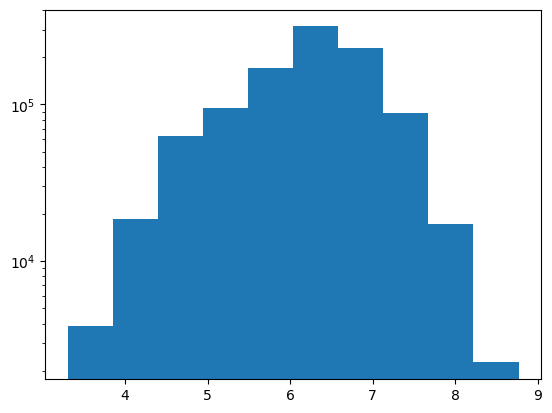

In [3]:
rl= rgal
print('rgal=', rgal)
print('rl=',rl)
corte,=np.where((xn_str <rl) & (yn_str <rl) & (zn_str <rl) & (xn_str >-rl) & (yn_str >-rl) & (zn_str >-rl))

nb1 = 50
npixel = 1000

particles=sph.Particles(pos_str[corte,:3],mstr[corte],nb=nb1)
escena=sph.Scene(particles)
escena.update_camera(r='infinity',x=0,y=0,z=0,extent=[-rl,rl,-rl,rl],xsize=npixel,ysize=npixel)
rend0=sph.Render(escena)
rend0.set_logscale()
rend0.histogram(log=True)

print('max=',rend0.get_max())
print('mix=',rend0.get_min())

In [4]:
rend0.get_max()

8.768297

In [5]:
rend0.get_min()

3.305306

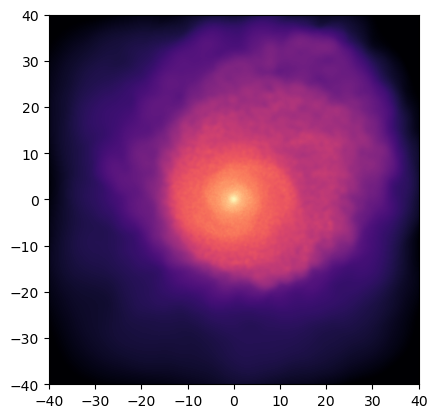

In [6]:
vmin = rend0.get_min()
vmax = rend0.get_max()

cmap='magma'

rl=40
corte,=np.where((xn_str <rl) & (yn_str <rl) & (zn_str <rl) & (xn_str >-rl) & (yn_str >-rl) & (zn_str >-rl))

nb1 = 50
npixel = 1000

particles = sph.Particles(pos_str[corte,:3], mstr[corte], nb=nb1)
escena = sph.Scene(particles)
escena.update_camera(r='infinity', x=0, y=0, z=0,
                     extent=[-rl, rl, -rl, rl], xsize=npixel, ysize=npixel)
rend = sph.Render(escena)
extent = escena.get_extent()
rend.set_logscale()

plt.imshow(rend.get_image(), extent=extent, origin='lower', cmap=cmap, vmin=vmin, vmax=vmax)